Introduction to ML - Decision Tree Coursework

In [2]:
import numpy as np

Step 1: Loading Data

In [3]:
# Reading in the datasets
clean_dataset = np.loadtxt('Dataset/clean_dataset.txt')
noisy_dataset = np.loadtxt('Dataset/noisy_dataset.txt')

In [4]:
print(clean_dataset.shape)

(2000, 8)


In [5]:
print(noisy_dataset.shape)

(2000, 8)


In [6]:
print(clean_dataset[1:5][2:4])

[[-61. -60. -68. -62. -77. -90. -80.   1.]
 [-63. -65. -60. -63. -77. -81. -87.   1.]]


In [7]:
np.unique(clean_dataset[:, -1])

array([1., 2., 3., 4.])

In [8]:
nique, counts = np.unique(clean_dataset[:,-1], return_counts=True)
# result = dict(zip(clean_dataset, counts))
print(len(nique))
print(counts)

4
[500 500 500 500]


Step 2: Creating Decision Trees

In [9]:
# Function to calculate entropy
def cal_entropy(dataset):

    nique, counts = np.unique(dataset[:,-1], return_counts=True)

    pk_values = []

    # calculating pk values
    for k in range(len(nique)):
        pk = counts[k]/len(dataset[:, -1])
        pk_values.append(pk)

    entropy = 0
    # calculating entropy based on pk values
    for pk in pk_values:
        entropy += (pk * np.log2(pk))

    return -1 * entropy

In [ ]:
# Function to calculate the best split feature and value
# We will iterate through all possible split points and calculate the info gain if we were to use the split point and update to using the best split (highest info gain)
def find_split(dataset):

    # Initialisation
    best_info_gain = -9999
    best_feature_index = None
    best_feature_value = None

    best_left_data = []
    best_right_data = []

    best_value = None

    entropy_complete_dataset = cal_entropy(dataset)

    # Loop through all features
    for feature_index in range(dataset.shape[1]-1):
        # Get unique feature values
        unique_feature_values = np.unique(dataset[:,feature_index])

        # Find all potential split points (midpoint between the values)
        potential_splits = []

        for i in range(len(unique_feature_values)-1):
            current_value = unique_feature_values[i]
            next_value = unique_feature_values[i+1]

            mid_value = (current_value+next_value)/2

            potential_splits.append(mid_value)

        # For every value in the potential splits, we calculate left and right datasets
        # we also calculate the information gain
        # we keep track of the best split value and attribute, along with the best left and right datasets
        for split_value in potential_splits:
            left_dataset_list = []
            right_dataset_list = []

            for row in dataset:
                if row[feature_index] <= split_value:
                    left_dataset_list.append(row)
                else:
                    right_dataset_list.append(row)
            
            # Initialising the new split datasets
            left_dataset = np.array(left_dataset_list)
            right_dataset = np.array(right_dataset_list)

            # Calculating the probabilities of new split datasets
            prob_left = len(left_dataset) / len(dataset)
            prob_right = len(right_dataset) / len(dataset)

            # Finding information gain based on the split
            information_gain = entropy_complete_dataset - (prob_left * cal_entropy(left_dataset) + (prob_right * cal_entropy(right_dataset)))
 
            # Checking in information gain on this split is better than the previous best
            if information_gain > best_info_gain:
                best_info_gain = information_gain
                best_feature_index = feature_index
                
                best_left_data = left_dataset
                best_right_data = right_dataset

                best_value = split_value

    return best_info_gain, best_feature_index, best_value, best_left_data, best_right_data

In [55]:
# Our node class
# Has left and right values which point to different nodes
# The split value and attribute index mentions what value and which attribute index we are going to be splitting on
# If the node is a leaf, isLeaf would return true and prediction would return the prediction for that node
class Node:
  def __init__(self, left = None, right = None, splitValue = None, attributeIndex = None,
   prediction = None) -> None:
    self.left = left
    self.right = right
    self.splitValue = splitValue
    self.attributeIndex = attributeIndex
    self.prediction = prediction

    self.x = 0.0

  @property
  def isLeaf(self) -> bool:
    # A node is a leaf if it has no left or right child
    return self.left is None and self.right is None

In [56]:
def decision_tree_learning(dataset, depth=0):

     # if the data has all the same values, then we have a leaf node
    unique_labels = np.unique(dataset[:,-1])
    if len(unique_labels)==1:
        leafNode = Node(prediction=unique_labels[0])
        return leafNode, depth

    # otherwise, we get the best values for split, and create a new node
    best_info_gain, best_feature_index, best_value, left_data, right_data = find_split(dataset)

    # Best feature index 
    # best info gain
    # best feature value
    node = Node(splitValue=best_value,
                attributeIndex=best_feature_index)
    node.left, l_depth = decision_tree_learning(left_data, depth + 1)
    node.right, r_depth = decision_tree_learning(right_data, depth + 1)

    return (node, max(l_depth, r_depth))

Tree Visualisation  

*Taken Inspiration from the Reingold-Tilford Algorithm*

In [ ]:
import matplotlib.pyplot as plt

# First we need to assign all the leafs an x-coordinate. For this we use post order tree traversal

def assign_leaf_x_coords(node, x_counter_list):
    
    # 1. Recurse left
    if node.left:
        assign_leaf_x_coords(node.left, x_counter_list)
        
    # 2. Recurse right
    if node.right:
        assign_leaf_x_coords(node.right, x_counter_list)
    
    # 3. Check if leaf, assign coordinate
    if node.isLeaf:
        # This is a leaf, assign it the next x-coordinate
        node.x = x_counter_list[0] 
        x_counter_list[0] += 1
    
# Next for each parent node we assign coords by calculating midpoint, used post order traversal again.

def assign_parent_x_coords(node):
    
    if node.isLeaf:
        # A leaf's x is already set. It is its own leftmost and rightmost point.
        return node.x, node.x
    else:
        # We must recurse *first* (post-order) so the children's x are set
        left_min, left_max = 0.0, 0.0
        right_min, right_max = 0.0, 0.0
        
        if node.left:
            left_min, left_max = assign_parent_x_coords(node.left)
        
        if node.right:
            right_min, right_max = assign_parent_x_coords(node.right)
        
        
        if node.left and node.right:
            # Center between the two children
            node.x = (node.left.x + node.right.x) / 2.0
        elif node.left:
            # Align with the single left child
            node.x = node.left.x
        elif node.right:
            # Align with the single right child
            node.x = node.right.x
        
        
        # Return the min and max x-span of this *entire* subtree
        if node.left and node.right:
            return left_min, right_max
        elif node.left:
            return left_min, left_max
        elif node.right:
            return right_min, right_max
        else:
            return node.x, node.x

def draw_recursive(ax, node, depth, max_depth):

    # We print the nodes using a top down approach using a pre order traversal
    # Calculate y-coordinate from depth (root is at top)
    y = max_depth - depth
    
    # Box formatting
    box_style = dict(boxstyle='round,pad=0.5', fc='w', lw=1)
    fontsize = 10

    
    if node.isLeaf:
        node_text = f"leaf:{node.prediction:.1f}" 
        box_style['ec'] = 'g' # Green box for leaves
        ax.text(node.x, y, node_text, ha='center', va='center', bbox=box_style, color='g', fontsize=fontsize)
    else:
        node_text = f"[X{node.attributeIndex} < {node.splitValue:.1f}]"
        box_style['ec'] = 'b' # Blue box for decisions
        ax.text(node.x, y, node_text, ha='center', va='center', bbox=box_style, color='b', fontsize=fontsize)
        
        # Draw branches to children
        y_child = y - 1
        if node.left:
            ax.plot([node.x, node.left.x], [y, y_child], 'k-') # Black line
            draw_recursive(ax, node.left, depth + 1, max_depth)
        
        if node.right:
            ax.plot([node.x, node.right.x], [y, y_child], 'k-') # Black line
            draw_recursive(ax, node.right, depth + 1, max_depth)

def visualize_tree(tree, title="Decision Tree"):
    
    
    # Get root and the depth
    root_node = tree[0]
    max_depth = tree[1]
    
    
    # Counting total number of leaves
    x_counter = [0]
    assign_leaf_x_coords(root_node, x_counter) 
    total_leaves = x_counter[0]
    
    
    assign_parent_x_coords(root_node) # Pass the node, not the tuple
    
    # Setting up the plot
    fig_width = max(15, total_leaves * 0.7)
    fig_height = max(8, max_depth * 0.9)
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    fig.suptitle(title, fontsize=16)
    ax.axis('off')
    
    
    ax.set_xlim(-1, total_leaves)
    ax.set_ylim(-1, max_depth + 1)

    
    draw_recursive(ax, root_node, 0, max_depth) # Pass the node
    
    # Display the plot
    plt.tight_layout()
    plt.show()





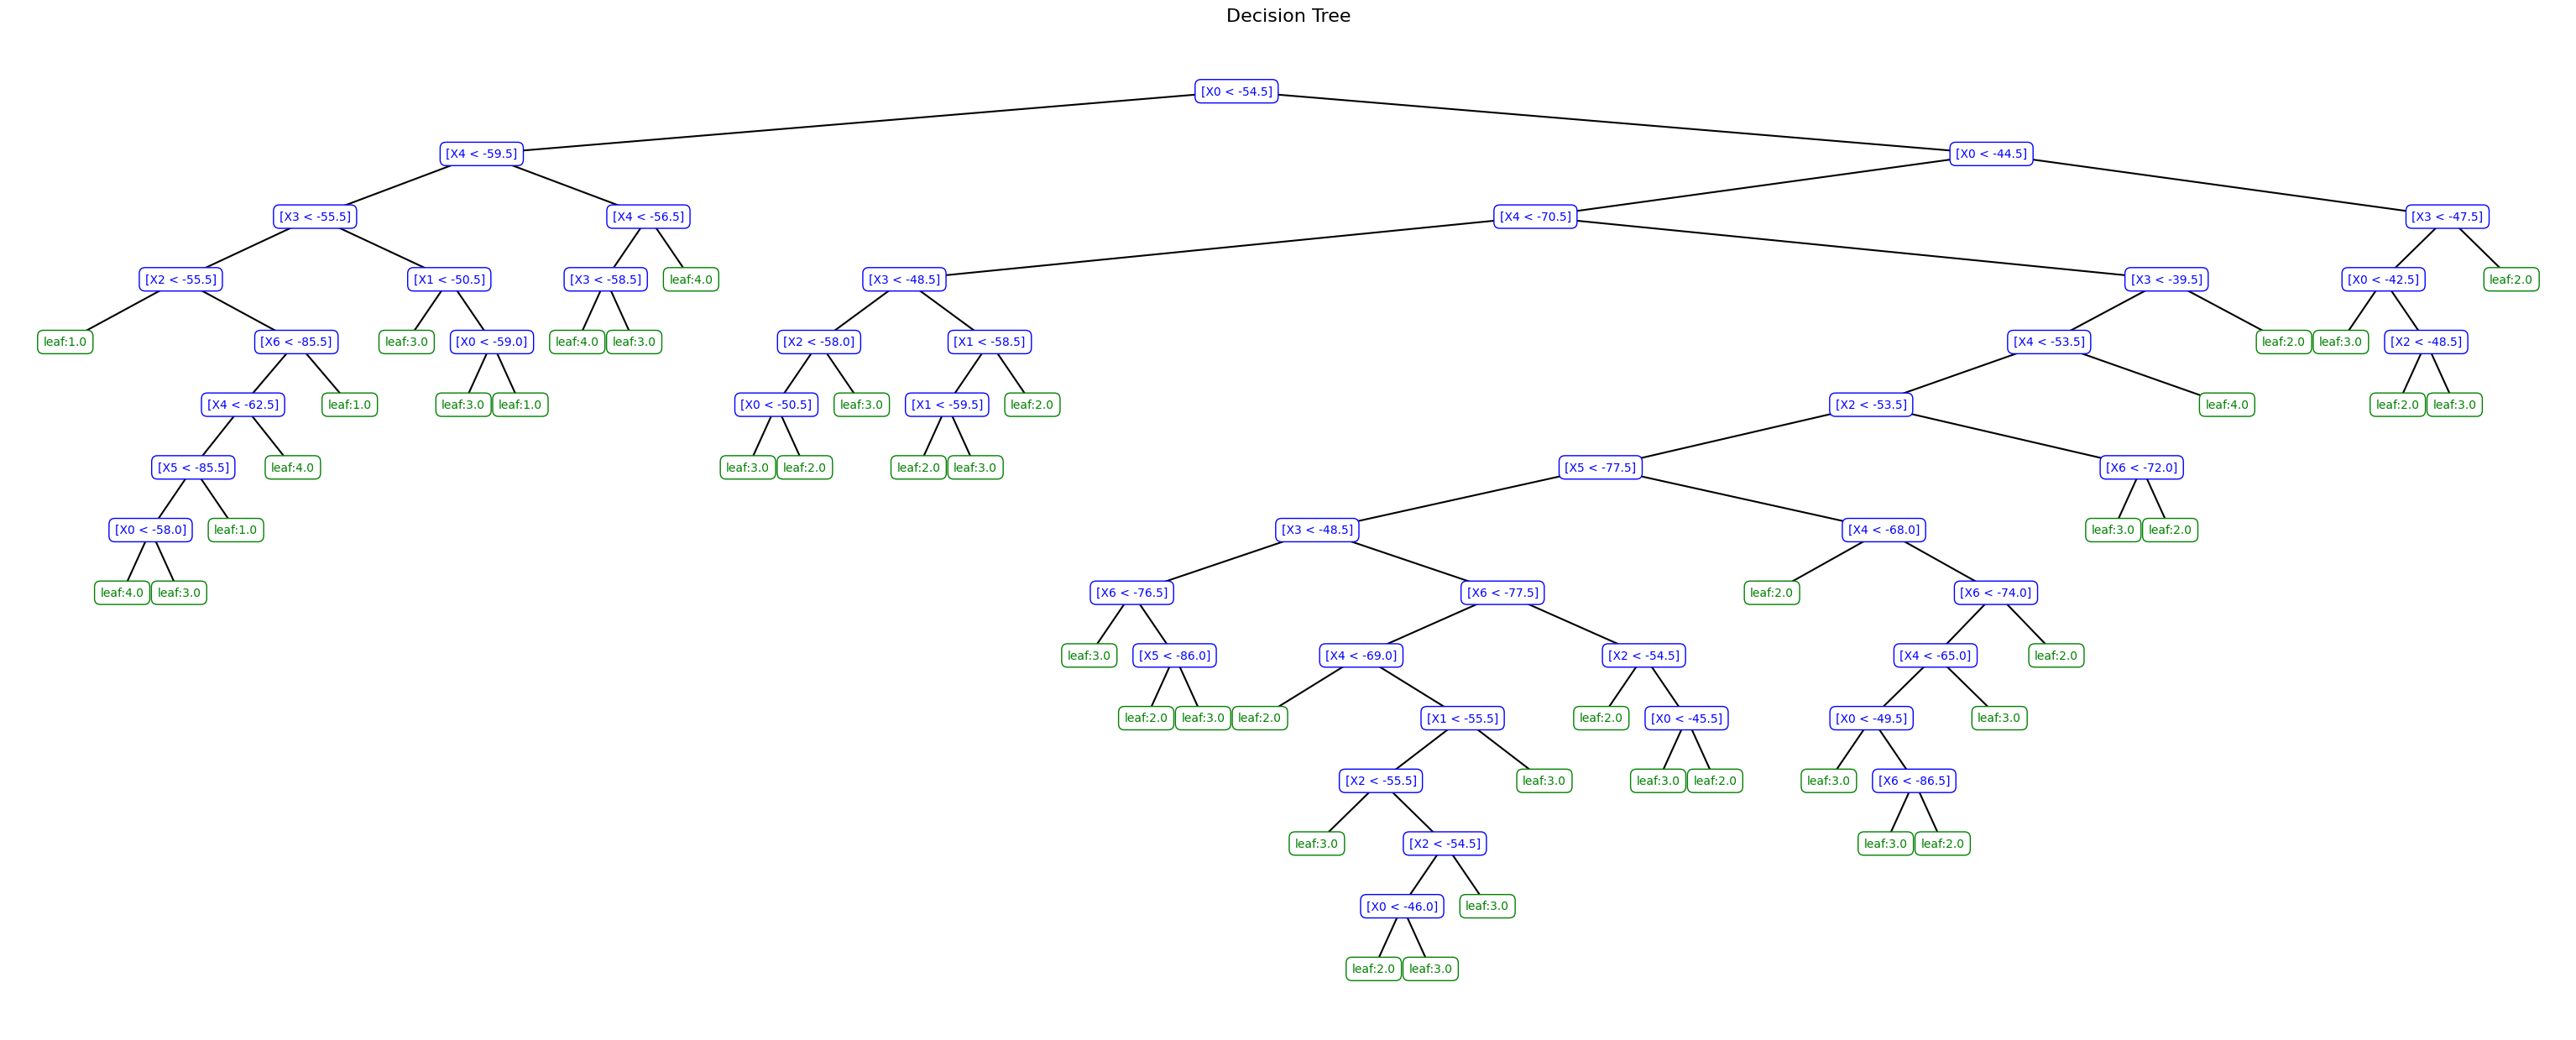

In [62]:
clean_tree = decision_tree_learning(clean_dataset)
visualize_tree(clean_tree)

In [24]:
# function to shuffle data indices and split values
def kfold_datasets_generator(dataset):

    working_data = dataset.copy()
    print(working_data.shape)
    np.random.shuffle(working_data)
    split_datasets = np.split(working_data, 10)
    print(len(split_datasets))
    print(split_datasets[0].shape)

    # Okay, now we have 10 datasets. We need to focus on training the tree on the first 9 and evaluate on the last 1

    l = []
    for i in range(len(split_datasets)):
        # The ith set will be the testing set, the rest will be the training set
        testing_set = split_datasets[i]
        training_set = split_datasets[:i] + split_datasets[i + 1:]

        training_set = np.concatenate((training_set), axis = 0)

        d = {'testing': testing_set, 'training': training_set}
        l.append(d)
    
    # this function returns a list of 10 dictionaries, with each dictionary having a 'training' and 'testing' key
    # the keys point to their respective training and testing dataset
    
    return l

In [25]:
def get_prediction(node: Node, input):

    # given an input of size (1, 8), we follow the decision tree, and return the final predicted value
    val = node.splitValue
    index = node.attributeIndex
    if node.isLeaf:
        return node.prediction
    if input[index] <= val:
        return get_prediction(node.left, input)
    else:
        return get_prediction(node.right, input)

In [26]:
def kfold_evaluator(datasets):

    # to track the accuracy of all of our folds
    all_fold_accuracies = []
    
    
    for i in datasets:
        # we loop through every dataset and train a decision tree on the training data
        node, depth = decision_tree_learning(i['training'], 0)

        confusion_matrix = [[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]

        # for every row in the training data, we get a predicted and actual value, then build our confusion matrix based on that
        for j in range(len(i['testing'])):
            predicted = get_prediction(node, i['testing'][j])
            actual = i['testing'][j][-1]
            predicted.astype(np.int64)
            predicted = predicted.astype(np.int64)
            actual = actual.astype(np.int64)
            confusion_matrix[predicted - 1][actual - 1] += 1
        confusion_matrix = np.array(confusion_matrix)
        print(confusion_matrix)

        print("-" * 30)

        # --- Integrated Statistics Calculation ---
        
        print("--- Per-Class Statistics ---")
        
        precision_scores = []
        recall_scores = []

        for k in range(4): # Use 'k' to avoid shadowing the outer 'i'
            class_name = f"Class {k+1}"

            # True Positives: Correctly predicted for this class
            true_positives = confusion_matrix[k, k]
            
            # False Positives: Predicted as this class, but was actually another
            # Sum of row 'k', minus the TP
            false_positives = np.sum(confusion_matrix[k, :]) - true_positives
            
            # False Negatives: Actually this class, but predicted as another
            # Sum of column 'k', minus the TP
            false_negatives = np.sum(confusion_matrix[:, k]) - true_positives

            # --- Calculate Precision ---
            # TP / (TP + FP)
            precision_denominator = (true_positives + false_positives)
            if precision_denominator == 0:
                precision = 0.0
            else:
                precision = true_positives / precision_denominator
            
            precision_scores.append(precision)

            # --- Calculate Recall ---
            # TP / (TP + FN)
            recall_denominator = (true_positives + false_negatives)
            if recall_denominator == 0:
                recall = 0.0
            else:
                recall = true_positives / recall_denominator
            
            recall_scores.append(recall)

            print(f"{class_name}:")
            print(f"  True Positives:  {true_positives}")
            print(f"  False Positives: {false_positives}")
            print(f"  False Negatives: {false_negatives}")
            print(f"  Precision:       {precision:.4f}")
            print(f"  Recall:          {recall:.4f}")

        print("-" * 30)
        print("--- Overall Statistics (for this fold) ---")
        
        # Overall Accuracy = (Sum of all correct) / (Total samples)
        total_correct = np.trace(confusion_matrix) # Sum of the diagonal
        total_samples = np.sum(confusion_matrix)
        
        if total_samples == 0:
            overall_accuracy = 0.0
        else:
            overall_accuracy = total_correct / total_samples
            
        all_fold_accuracies.append(overall_accuracy)

        print(f"Overall Accuracy: {overall_accuracy:.4f}")
        print(f"Average Precision: {np.mean(precision_scores):.4f}")
        print(f"Average Recall: {np.mean(recall_scores):.4f}")
        print("=" * 30 + "\n")


    print("--- Final K-Fold Summary ---")
    if len(all_fold_accuracies) > 0:
        print(f"Average Overall Accuracy across all folds: {np.mean(all_fold_accuracies):.4f}")
    else:
        print("No datasets were processed.")

In [27]:
datasets = kfold_datasets_generator(noisy_dataset)
kfold_evaluator(datasets)

(2000, 8)
10
(200, 8)
[[48  1  0  3]
 [ 3 40  1  2]
 [ 0  4 47  3]
 [ 4  4  2 38]]
------------------------------
--- Per-Class Statistics ---
Class 1:
  True Positives:  48
  False Positives: 4
  False Negatives: 7
  Precision:       0.9231
  Recall:          0.8727
Class 2:
  True Positives:  40
  False Positives: 6
  False Negatives: 9
  Precision:       0.8696
  Recall:          0.8163
Class 3:
  True Positives:  47
  False Positives: 7
  False Negatives: 3
  Precision:       0.8704
  Recall:          0.9400
Class 4:
  True Positives:  38
  False Positives: 10
  False Negatives: 8
  Precision:       0.7917
  Recall:          0.8261
------------------------------
--- Overall Statistics (for this fold) ---
Overall Accuracy: 0.8650
Average Precision: 0.8637
Average Recall: 0.8638

[[35  3  2  2]
 [ 3 44  2  2]
 [ 4  8 46  1]
 [ 2  1  2 43]]
------------------------------
--- Per-Class Statistics ---
Class 1:
  True Positives:  35
  False Positives: 7
  False Negatives: 9
  Precision: 